In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor


import warnings
warnings.filterwarnings('ignore')

In [97]:
df = pd.read_csv(r'D:\Data Science\Capstone Project\Capstone Project 3\bike_sharing\data\raw\data_bike_sharing.csv')

In [98]:
df['dteday'] = pd.to_datetime(df['dteday'])

df['year'] = df['dteday'].dt.year
df['month'] = df['dteday'].dt.month
df['date'] = df['dteday'].dt.day
df['day'] = df['dteday'].dt.weekday

# day_dict = {0:'Monday', 1:'Teusday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
# df['day'] = df['day'].map(day_dict)

df['is_weekday'] = df['day'].isin([0,1,2,3,4]).astype(int)

df = df.drop(['dteday'], axis=1)

In [99]:
print('Missing values:', df.isnull().sum().sum())

Missing values: 0


In [100]:
print('Duplicate rows:', df.duplicated().sum())

Duplicate rows: 0


In [101]:
df = df.rename({'hum':'humidity','weathersit':'weather','hr':'hour','cnt':'count', 'atemp':'feeling_temp'}, axis=1)

In [102]:
df = df[df['humidity'] != 0]

In [103]:
df1 = df.drop(['casual', 'registered'], axis=1)

# EDA

# Split Data

In [108]:
seen_data, unseen_data = train_test_split(df1, test_size=0.2, random_state=42)

print(seen_data.shape)
print(unseen_data.shape)

(9720, 13)
(2431, 13)


In [109]:
training_data, testing_data = train_test_split(seen_data, test_size=0.3,
                                                    random_state=42)

print(training_data.shape)
print(testing_data.shape)

(6804, 13)
(2916, 13)


In [110]:
independen = df1.drop(['count'], axis=1)
vif_data = pd.DataFrame()
vif_data['Variable'] = independen.columns  # Nama variabel
vif_data['VIF'] = [variance_inflation_factor(independen.values, i) for i in range(independen.shape[1])]

# show values of VIF
print(vif_data)

        Variable         VIF
0       humidity   16.649561
1        weather    7.575649
2        holiday    1.080839
3         season   20.889282
4   feeling_temp  354.887062
5           temp  312.977164
6           hour    4.233842
7           year   56.160151
8          month   14.838949
9           date    4.173375
10           day    9.040179
11    is_weekday    9.402608


# Feature

In [198]:
X_train = training_data.drop(['count','feeling_temp','season'], axis=1)
y_train = training_data['count']

X_test = testing_data.drop(['count','feeling_temp','season'], axis=1)
y_test = testing_data['count']

In [112]:
#training data
print("training data feature shape: ",X_train.shape)
print("training data target shape: ",y_train.shape)

#test data
print("test data feature shape: ",X_test.shape)
print("test data target shape: ",y_test.shape)

training data feature shape:  (6804, 10)
training data target shape:  (6804,)
test data feature shape:  (2916, 10)
test data target shape:  (2916,)


In [113]:
from scipy.stats import boxcox
from feature_engine.creation import CyclicalFeatures
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [115]:
# Fungsi untuk log-transform dengan offset
def safe_log_transform(X, offset=1e-6):
    return np.log(X + offset)

log_transformer = FunctionTransformer(safe_log_transform, validate=True)

CyclicalFeatures from feature_engine.creation -> Untuk menangkap pola cyclic pada kolom month, hour, date. setelah cyclicalfeatures, data di scaling menggunakan robust scaler. 
Robust Scaler -> menyamakan skala fitur numerik ['month','hour','day','date','year']. dipilih karena terdapat outliers pada data dan robustscaling tahan terhadap outliers.
One Hot Encoding -> mengubah fitur kategori menjadi fitur numerik. fitur yang di one hot encoding adalah fitur 'month','hour','day','date','weather','year', 'weather'
KBinsDiscreatizer from sklearn.preprocessing -> mengubah fitur numerik menjadi fitur kategori mengatasi distribusi tidak normal pada fitur numerik. fitur yang dipilih adalah fitur 'temperature' dan 'humidity' karena distribusi tidak normal.

In [178]:
# Pipeline untuk Fitur Siklik
cyclical_transformer = Pipeline([
    ('cyclical_features', (
        variables=['hour','month','date','day'],  # Fitur siklik
        max_values={'hour': 24,'month': 12,'date': 31,'day': 7},  # Nilai maksimum untuk setiap fitur siklik,
        drop_original=True  # Nilai maksimum untuk setiap fitur siklik
    )),
    ('robscal', RobustScaler()) # StandardScaler
])

ohe_robust = Pipeline([
    ('ohe', OneHotEncoder(drop='first')),
    ('robscale', RobustScaler(with_centering=False))
])

In [233]:
transforms = ColumnTransformer(
    transformers=[
        ("Hum, Temp,", KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform"), ["humidity", "temp"]),
        ('or', cyclical_transformer, ['month','hour','day','date']),
        ('ohe',OneHotEncoder(drop='first'),['weather']),
        ('year', RobustScaler(),['year']) # Encoding kategorikal
    ],
    remainder='passthrough', verbose_feature_names_out=False  # Biarkan fitur lainnya tetap
)

transformsKB = ColumnTransformer(
    transformers=[
        ("Hum, Temp,", KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform"), ["humidity", "temp"]),
        ('ohe', ohe_robust, ['month','hour','day','date','weather','year']),
    ],
    remainder='passthrough', verbose_feature_names_out=False  # Biarkan fitur lainnya tetap
)


In [200]:
transforms.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('Hum, Temp,',
                                 KBinsDiscretizer(encode='ordinal',
                                                  strategy='uniform'),
                                 ['humidity', 'temp']),
                                ('or',
                                 Pipeline(steps=[('cyclical_features',
                                                  CyclicalFeatures(drop_original=True,
                                                                   max_values={'date': 31,
                                                                               'day': 7,
                                                                               'hour': 24,
                                                                               'month': 12},
                                                                   variables=['hour',
                                                                              'month',
                                                                              'date',
                                                                              'day'])),
                                                 ('robscal', RobustScaler())]),
                                 ['month', 'hour', 'day', 'date']),
                                ('ohe', OneHotEncoder(drop='first'),
                                 ['weather']),
                                ('year', RobustScaler(), ['year'])],
                  verbose_feature_names_out=False)

In [201]:
transformsKB.fit(X_train,y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('Hum, Temp,',
                                 KBinsDiscretizer(encode='ordinal',
                                                  strategy='uniform'),
                                 ['humidity', 'temp']),
                                ('ohe',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first')),
                                                 ('robscale',
                                                  RobustScaler(with_centering=False))]),
                                 ['month', 'hour', 'day', 'date', 'weather',
                                  'year'])],
                  verbose_feature_names_out=False)

In [20]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.compose import TransformedTargetRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV, KFold, cross_validate



# errors
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, make_scorer, mean_squared_error, r2_score

from sklearn.utils import parallel_backend

In [83]:
# Pipeline
base_reg = Pipeline(steps=[
    ('FeatureEngineering', transforms),
    ('Regression', None)  # Placeholder for model
])

# Pipeline
base_regKB = Pipeline(steps=[
    ('FeatureEngineering', transformsKB),
    ('Regression', None)  # Placeholder for model
])

## Function

In [22]:
scoring = {
    'rmse': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}

In [153]:
def evaluate_models(models_log, transformer, X_train, y_train, scoring):
    """
    Evaluate multiple models using cross-validation and return performance metrics as a DataFrame.

    Parameters:
    - models_log (list): List of model objects to evaluate.
    - transformer: Preprocessing pipeline or transformer object.
    - X_train: Training features.
    - y_train: Training target.
    - scoring (dict): Dictionary of scoring metrics for cross-validation.

    Returns:
    - pd.DataFrame: DataFrame containing mean and std of scores for each metric.
    """
    results = {
        "Model": [],
        "Mean_RMSE": [], "Std_RMSE": [],
        "Mean_MAE": [], "Std_MAE": [],
        "Mean_MAPE": [], "Std_MAPE": [],
        "Mean_R2": [], "Std_R2": []
    }

    for model in models_log:
        model_name = type(model.regressor).__name__  # Nama model dari regressor asli
            
        results["Model"].append(model_name)

        pipe_model = Pipeline([
            ("preprocess", transformer),
            ("model", model)
        ])

        cv = KFold(n_splits=5, shuffle=True, random_state=19)

        cv_score = cross_validate(
            estimator=pipe_model,
            X=X_train,
            y=y_train,
            cv=cv,
            scoring=scoring,
            error_score="raise"
        )

        results["Mean_RMSE"].append(cv_score["test_rmse"].mean())
        results["Std_RMSE"].append(cv_score["test_rmse"].std())

        results["Mean_MAE"].append(cv_score["test_mae"].mean())
        results["Std_MAE"].append(cv_score["test_mae"].std())

        results["Mean_MAPE"].append(cv_score["test_mape"].mean())
        results["Std_MAPE"].append(cv_score["test_mape"].std())

        results["Mean_R2"].append(cv_score["test_R2"].mean())
        results["Std_R2"].append(cv_score["test_R2"].std())

    return pd.DataFrame(results).sort_values("Mean_R2", ascending=False)

## Base Model_Log

### Model

In [151]:
log_linear = TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp)
log_ridge = TransformedTargetRegressor(Ridge(random_state=42), func=np.log, inverse_func=np.exp)
log_lasso = TransformedTargetRegressor(Lasso(random_state=42), func=np.log, inverse_func=np.exp)
log_tree = TransformedTargetRegressor(DecisionTreeRegressor(random_state=42), func=np.log, inverse_func=np.exp)
log_forest = TransformedTargetRegressor(RandomForestRegressor(random_state=42), func=np.log, inverse_func=np.exp)
log_gboost = TransformedTargetRegressor(GradientBoostingRegressor(random_state=42), func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(XGBRegressor(random_state=42, categorical_enable=True), func=np.log, inverse_func=np.exp)

models_log = [log_linear, log_ridge, log_lasso, log_tree, log_forest, log_gboost, log_xgb]

In [202]:
results1 = evaluate_models(models_log, transforms, X_train, y_train, scoring)

In [203]:
results1KB = evaluate_models(models_log, transformsKB, X_train, y_train, scoring)

In [193]:
# Without Year
# display(results1,results1KB)

,Model,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE,Mean_R2,Std_R2
6,XGBRegressor,-63.715423,1.363025,-40.187045,0.694958,-0.320140,0.012735,0.876828,0.006575
4,RandomForestRegressor,-76.617365,4.822062,-49.417917,2.272640,-0.389161,0.013578,0.822181,0.014714
5,GradientBoostingRegressor,-89.049995,3.975379,-56.347327,1.991413,-0.449839,0.022155,0.759824,0.012267
3,DecisionTreeRegressor,-103.144331,3.756004,-63.550698,2.136268,-0.547593,0.020830,0.677370,0.019881
1,Ridge,-165.024077,4.420014,-107.371138,3.467348,-1.102254,0.063013,0.174262,0.038535
0,LinearRegression,-165.110661,4.387862,-107.431079,3.455683,-1.102256,0.063006,0.173383,0.038622
2,Lasso,-205.544177,6.316430,-143.345704,3.427046,-3.683733,0.233114,-0.279347,0.005306


,Model,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE,Mean_R2,Std_R2
6,XGBRegressor,-86.925521,3.527019,-56.374525,2.062849,-0.457025,0.016307,0.771259,0.006661
4,RandomForestRegressor,-88.636871,3.195962,-57.317548,2.075691,-0.502811,0.011921,0.762043,0.008096
5,GradientBoostingRegressor,-112.078436,3.373967,-71.032755,2.542945,-0.629215,0.027031,0.619519,0.007998
3,DecisionTreeRegressor,-112.633844,3.469459,-71.569145,1.934790,-0.650677,0.026821,0.615247,0.021503
0,LinearRegression,-114.598372,4.200056,-74.048686,2.819683,-0.662864,0.024387,0.602046,0.018841
1,Ridge,-114.879449,4.244293,-74.144959,2.856117,-0.663398,0.024260,0.600130,0.018291
2,Lasso,-205.544177,6.316430,-143.345704,3.427046,-3.683733,0.233114,-0.279347,0.005306


In [205]:
# with Year
display(results1,results1KB)

,Model,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE,Mean_R2,Std_R2
6,XGBRegressor,-46.812640,1.656139,-28.479996,0.828335,-0.260675,0.011601,0.933462,0.005158
4,RandomForestRegressor,-52.435226,3.403377,-32.102228,1.494641,-0.311025,0.008726,0.916422,0.010072
3,DecisionTreeRegressor,-69.665850,2.605765,-41.579019,1.398159,-0.420588,0.013841,0.852760,0.009796
5,GradientBoostingRegressor,-71.062219,4.119114,-44.812980,1.958330,-0.386264,0.021556,0.846905,0.012911
1,Ridge,-157.882772,4.425395,-102.376242,2.640933,-1.057670,0.053462,0.243759,0.043618
0,LinearRegression,-157.975495,4.415440,-102.428148,2.631154,-1.057442,0.053331,0.242863,0.043722
2,Lasso,-205.544177,6.316430,-143.345704,3.427046,-3.683733,0.233114,-0.279347,0.005306


,Model,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE,Mean_R2,Std_R2
6,XGBRegressor,-64.025897,4.484741,-39.839283,2.416029,-0.376464,0.016477,0.875683,0.012942
4,RandomForestRegressor,-74.038352,2.830829,-46.027803,0.851758,-0.476468,0.020798,0.833325,0.015988
3,DecisionTreeRegressor,-92.578370,2.377043,-54.960766,1.093440,-0.622347,0.038806,0.739325,0.023309
0,LinearRegression,-100.079178,3.335498,-65.636222,2.095366,-0.610787,0.024386,0.696140,0.019402
1,Ridge,-100.409373,3.337266,-65.784940,2.120255,-0.612177,0.024668,0.694167,0.018944
5,GradientBoostingRegressor,-101.358071,2.413254,-64.910166,2.129161,-0.597986,0.032277,0.688634,0.009963
2,Lasso,-205.544177,6.316430,-143.345704,3.427046,-3.683733,0.233114,-0.279347,0.005306


### Predict

In [221]:
# Benchmark 3 model terbaik
best_models = {"XGB": log_xgb}

score_rmse = []
score_mae = []
score_mape = []

# Prediksi pada test set
for i in best_models:

    model = Pipeline([
        ('preprocessing', transforms),
        ('model', best_models[i])
        ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score_rmse.append(rmse(y_test, y_pred))
    score_mae.append(mean_absolute_error(y_test, y_pred))
    score_mape.append(mean_absolute_percentage_error(y_test, y_pred))

score_before_tuning = pd.DataFrame(
    {
        "RMSE": score_rmse,
        "MAE": score_mae,
        "MAPE": score_mape
    },
    index=best_models.keys()
)

score_before_tuning

,RMSE,MAE,MAPE
XGB,44.764639,27.472225,0.25054


# Hyperparameter Tunning 1

## GridSearch

In [226]:
from sklearn.model_selection import GridSearchCV

pipe_model = Pipeline([
        ("preprocessing", transforms),
        ("modeling", log_xgb)
    ])

hyperparm = {
    "modeling__regressor__max_depth": [3,5,7],
    "modeling__regressor__learning_rate":  [0.1,0.5,0.9],
    "modeling__regressor__n_estimators": [100, 250, 500],
    "modeling__regressor__subsample":  [0.1,0.5,0.9],
    "modeling__regressor__gamma": [0,5,10],
    "modeling__regressor__colsample_bytree": [0.1,0.5,0.9],
    "modeling__regressor__reg_alpha": [0.01,0.1,1]
}
 

cv = KFold(n_splits=5, shuffle=True, random_state=42)

tuning1 = GridSearchCV(
    estimator=pipe_model,
    param_grid=hyperparm,
    scoring={
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "mape": "neg_mean_absolute_percentage_error"
    },
    refit="rmse",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    return_train_score=True,
    verbose=1
)

tuning1.fit(X_train, y_train)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Hum, '
                                                                         'Temp,',
                                                                         KBinsDiscretizer(encode='ordinal',
                                                                                          strategy='uniform'),
                                                                         ['humidity',
                                                                          'temp']),
                                                                        ('or',
                                                                         Pipeline(steps=[('cyclical_features',
                                                                                          CyclicalFeatures(drop_original=True,
                                                                                                           max_values={'date':...
                         'modeling__regressor__max_depth': [3, 5, 7],
                         'modeling__regressor__n_estimators': [100, 250, 500],
                         'modeling__regressor__reg_alpha': [0.01, 0.1, 1],
                         'modeling__regressor__subsample': [0.1, 0.5, 0.9]},
             refit='rmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',
                      'mape': 'neg_mean_absolute_percentage_error',
                      'rmse': 'neg_root_mean_squared_error'},
             verbose=1)

In [227]:
tuning1.best_params_

{'modeling__regressor__colsample_bytree': 0.9,
 'modeling__regressor__gamma': 0,
 'modeling__regressor__learning_rate': 0.1,
 'modeling__regressor__max_depth': 7,
 'modeling__regressor__n_estimators': 500,
 'modeling__regressor__reg_alpha': 1,
 'modeling__regressor__subsample': 0.9}

In [228]:
tuning1.best_score_

np.float64(-42.66191040595428)

## Predict

In [230]:
# Model XGBoost
best_model = {'XGB1':log_xgb}

# Define model with the best estimator
xgb_tuning = tuning1.best_estimator_

# Fitting model
xgb_tuning.fit(X_train, y_train)

# Predict to test data
y_pred_xgb_tuning = xgb_tuning.predict(X_test)

# Save the metrics after tunning
rmse_lgbm_tuning = rmse(y_test, y_pred_xgb_tuning)
mae_lgbm_tuning = mean_absolute_error(y_test, y_pred_xgb_tuning)
mape_lgbm_tuning = mean_absolute_percentage_error(y_test, y_pred_xgb_tuning)

score_after_tuning_1 = pd.DataFrame(
    {
    "RMSE": rmse_lgbm_tuning, 
    "MAE": mae_lgbm_tuning, 
    "MAPE": mape_lgbm_tuning
    },
    index=best_model.keys()
)

score_after_tuning_1

,RMSE,MAE,MAPE
XGB1,42.859295,25.655388,0.245877


In [231]:
pd.concat([score_before_tuning, score_after_tuning_1]).rename(index={0:'Before Tuning', 'XGB_1':'After Tuning'})    


,RMSE,MAE,MAPE
XGB,44.764639,27.472225,0.250540
XGB1,42.859295,25.655388,0.245877


# Tunning2

## GridSearch

In [222]:
hyperparam_tuning2 = {
    "modeling__regressor__max_depth": [6, 7, 8],  # Nilai sekitar hasil terbaik (7)
    "modeling__regressor__learning_rate": [0.05, 0.1, 0.15],  # Fokus di sekitar 0.1
    "modeling__regressor__n_estimators": [400, 500, 600],  # Fokus di sekitar 500
    "modeling__regressor__subsample": [0.8, 0.9, 1.0],  # Sekitar 0.9
    "modeling__regressor__gamma": [0, 1, 2],  # Sedikit menaikkan nilai dari 0
    "modeling__regressor__colsample_bytree": [0.8, 0.9, 1.0],  # Fokus di sekitar 0.9
    "modeling__regressor__reg_alpha": [0.5, 1, 1.5],  # Fokus di sekitar 1
}
 
tunning2 = GridSearchCV(
    estimator=pipe_model,
    param_grid=hyperparm,
    scoring={
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "mape": "neg_mean_absolute_percentage_error"
    },
    refit="rmse",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    return_train_score=True,
    verbose=1
)

tunning2.fit(X_train, y_train)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Hum, '
                                                                         'Temp,',
                                                                         KBinsDiscretizer(encode='ordinal',
                                                                                          strategy='uniform'),
                                                                         ['humidity',
                                                                          'temp']),
                                                                        ('or',
                                                                         Pipeline(steps=[('cyclical_features',
                                                                                          CyclicalFeatures(drop_original=True,
                                                                                                           max_values={'date':...
                         'modeling__regressor__max_depth': [3, 5, 7],
                         'modeling__regressor__n_estimators': [100, 250, 500],
                         'modeling__regressor__reg_alpha': [0.01, 0.1, 1],
                         'modeling__regressor__subsample': [0.1, 0.5, 0.9]},
             refit='rmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',
                      'mape': 'neg_mean_absolute_percentage_error',
                      'rmse': 'neg_root_mean_squared_error'},
             verbose=1)

In [223]:
tunning2.best_params_

{'modeling__regressor__colsample_bytree': 0.9,
 'modeling__regressor__gamma': 0,
 'modeling__regressor__learning_rate': 0.1,
 'modeling__regressor__max_depth': 7,
 'modeling__regressor__n_estimators': 500,
 'modeling__regressor__reg_alpha': 1,
 'modeling__regressor__subsample': 0.9}

# Residual

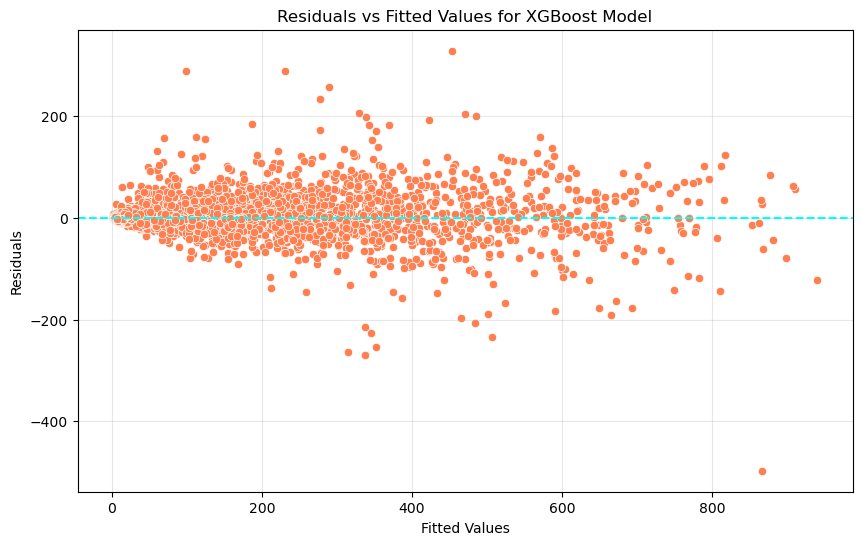

In [232]:
residuals = y_test - y_pred_xgb_tuning

# Create a scatter plot of residuals vs fitted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_xgb_tuning, y=residuals, color='coral')
plt.axhline(y=0, color='aqua', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values for XGBoost Model')
plt.grid(True, alpha=0.3)
plt.show()